In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, roc_curve
)

In [9]:
df=pd.read_csv('Predictive_maintenance .csv')
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [12]:
df.shape

(10000, 10)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


In [16]:
perc_null=df.isnull().sum()/df.shape[0]*100
print(perc_null)

UDI                        0.0
Product ID                 0.0
Type                       0.0
Air temperature [K]        0.0
Process temperature [K]    0.0
Rotational speed [rpm]     0.0
Torque [Nm]                0.0
Tool wear [min]            0.0
Target                     0.0
Failure Type               0.0
dtype: float64


In [20]:
df.duplicated().sum()

0

In [22]:
df.describe()


,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


In [26]:
df.describe(include=['object'])

,Product ID,Type,Failure Type
count,10000,10000,10000
unique,10000,3,6
top,M14860,L,No Failure
freq,1,6000,9652


In [28]:
print("\nValue Counts:")
for col in ['Type', 'Failure Type']:
    print(f"\n{col}:\n", df[col].value_counts())


Value Counts:

Type:
 Type
L    6000
M    2997
H    1003
Name: count, dtype: int64

Failure Type:
 Failure Type
No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: count, dtype: int64


### Dropping Irrelevant columns

In [31]:
df.drop(['UDI', 'Product ID'], axis=1, inplace=True)

### Encoding Type and Failure Type

In [34]:
df['Type'] = df['Type'].astype('category').cat.codes
df['Failure Type'] = df['Failure Type'].astype('category')


### Distribution Curves and Outlier Detection

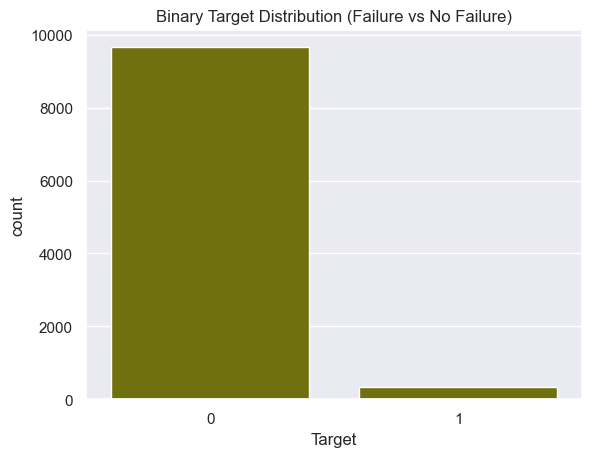

In [39]:
sns.countplot(data=df, x='Target',color='olive')
plt.title('Binary Target Distribution (Failure vs No Failure)')
plt.show()


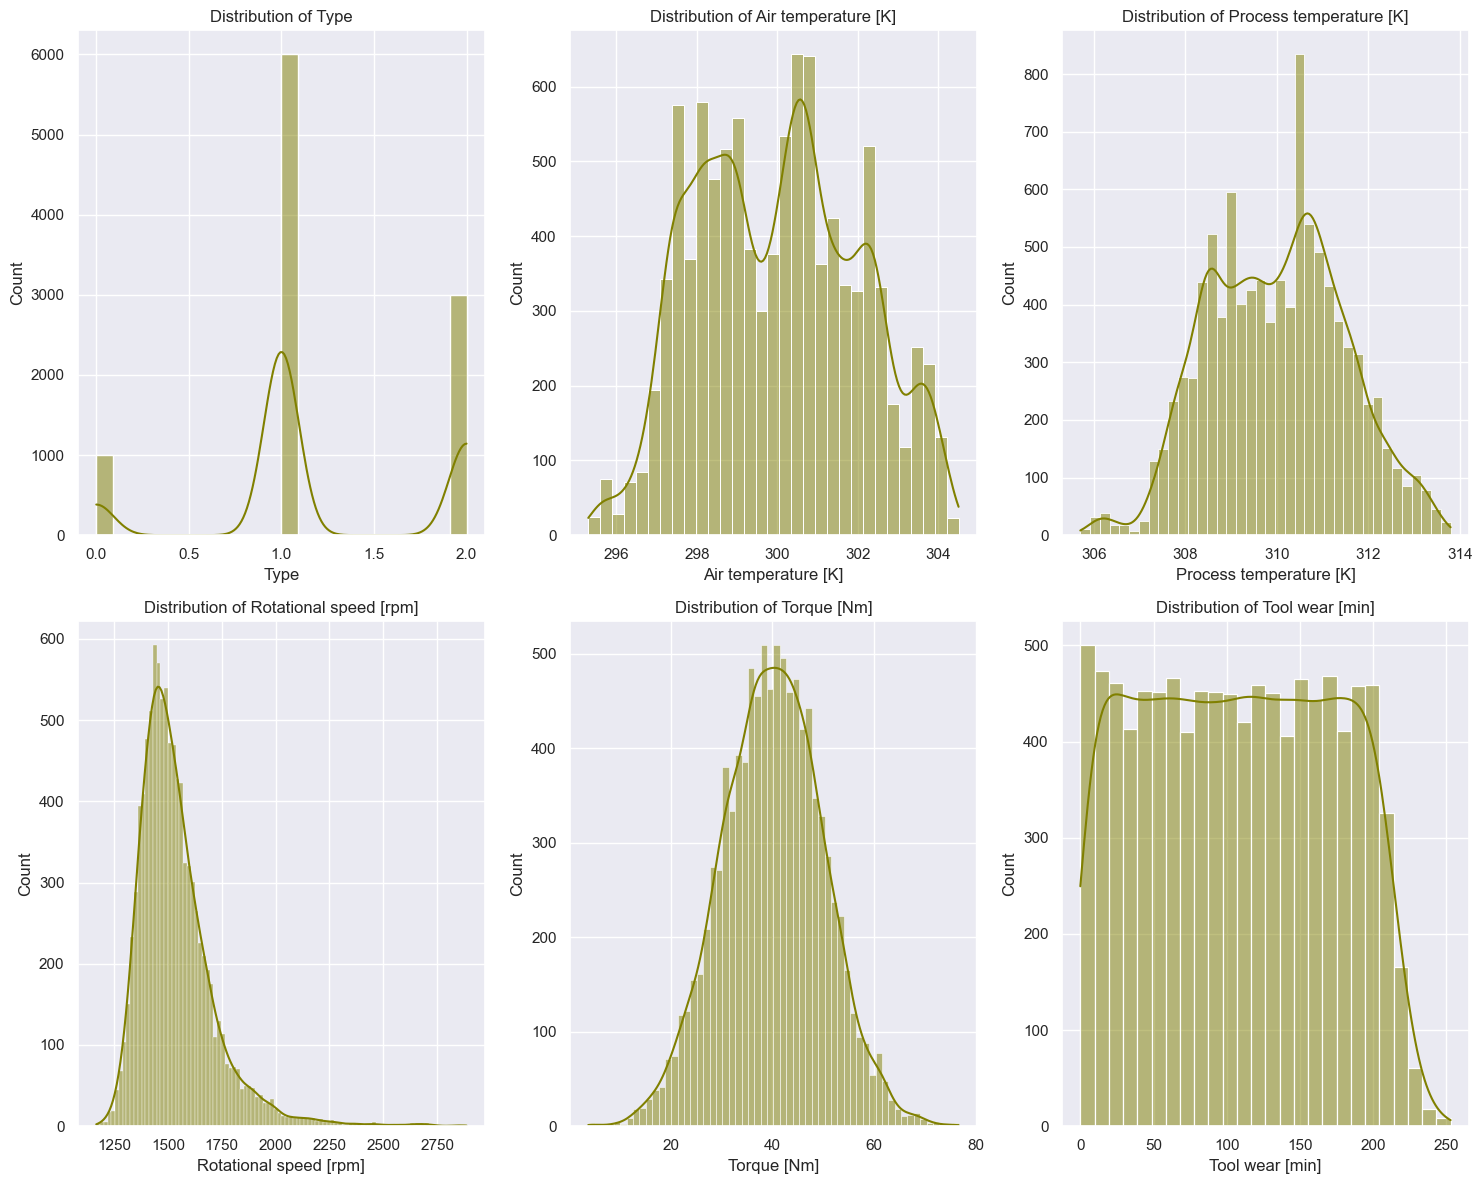

In [45]:
# Distribution plots for numerical columns
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols.remove('Target')

# Plot distribution for each numeric variable
fig, axs = plt.subplots(nrows=int(np.ceil(len(num_cols)/3)), ncols=3, figsize=(15, 12))
axs = axs.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(df[col], kde=True, ax=axs[i],color='olive')
    axs[i].set_title(f'Distribution of {col}')

plt.tight_layout()
plt.show()


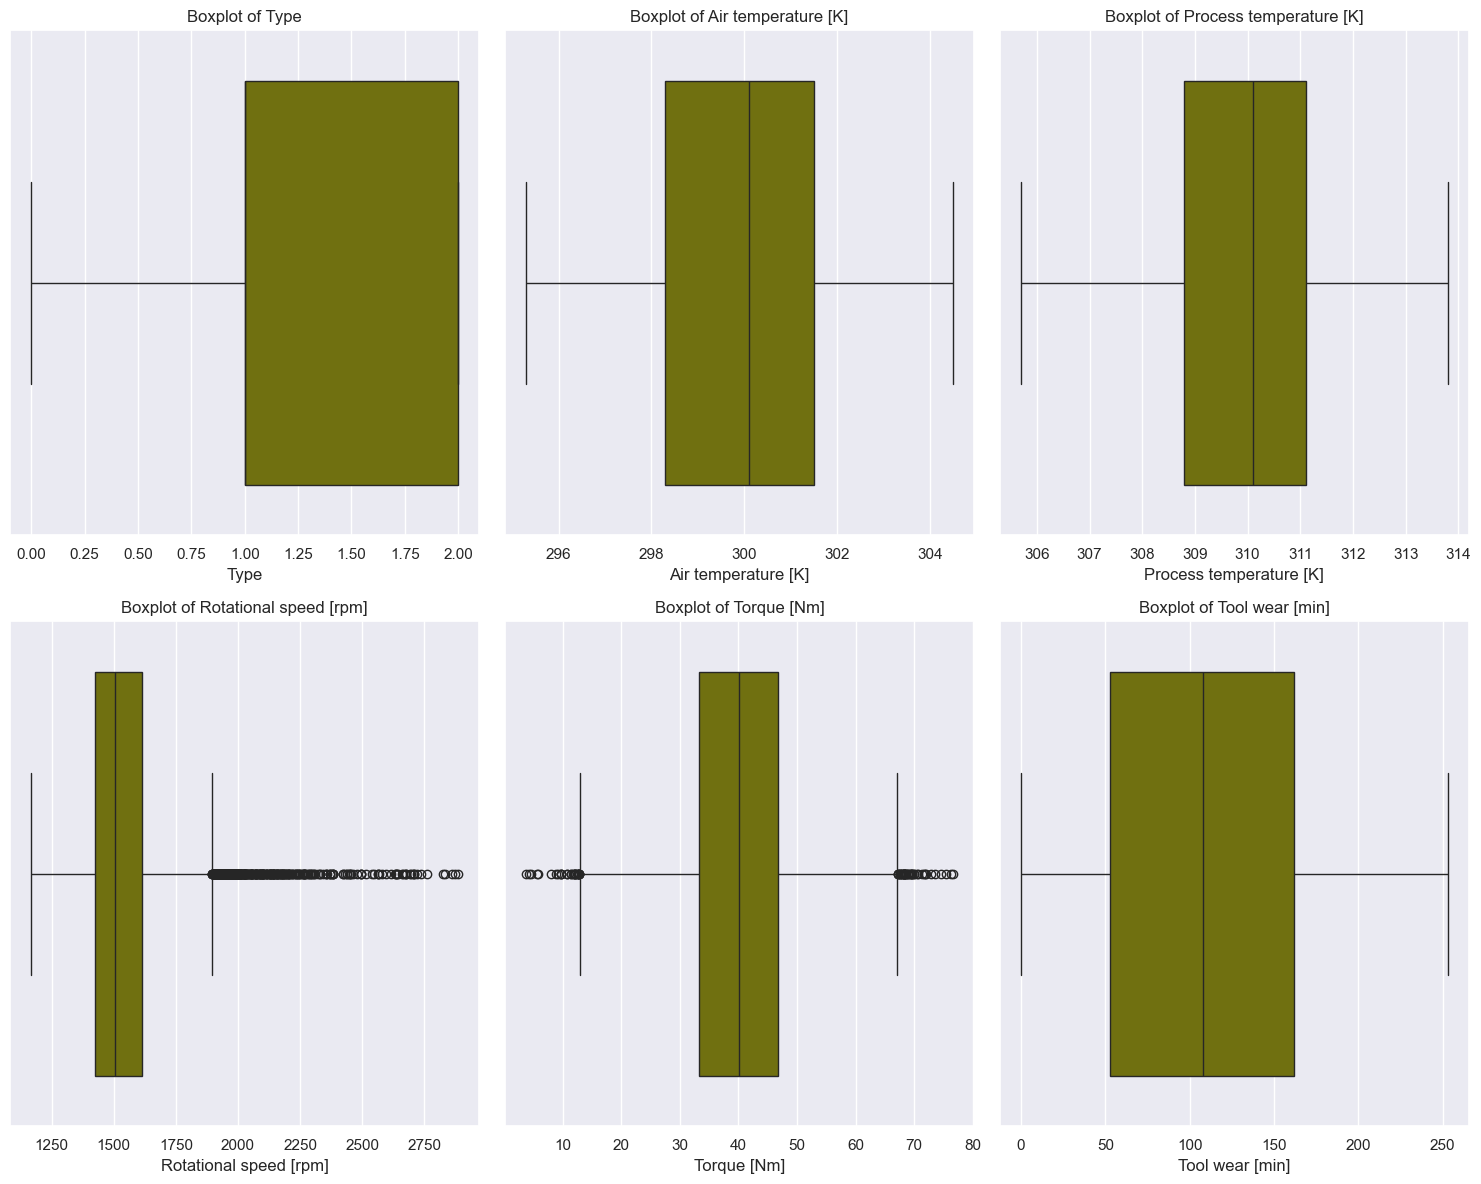

In [49]:
# Outlier detection via boxplots
fig, axs = plt.subplots(nrows=int(np.ceil(len(num_cols)/3)), ncols=3, figsize=(15, 12))
axs = axs.flatten()

for i, col in enumerate(num_cols):
    sns.boxplot(x=df[col], ax=axs[i],color='olive')
    axs[i].set_title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()

In [57]:
def detect_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[col] < lower) | (df[col] > upper)]

# Example usage
rot_outliers = detect_outliers(df, 'Rotational speed [rpm]')
torque_outliers = detect_outliers(df, 'Torque [Nm]')

print(f'Outliers in Rotational Speed: {len(rot_outliers)}')
print(f'Outliers in Torque: {len(torque_outliers)}')


Outliers in Rotational Speed: 418
Outliers in Torque: 69


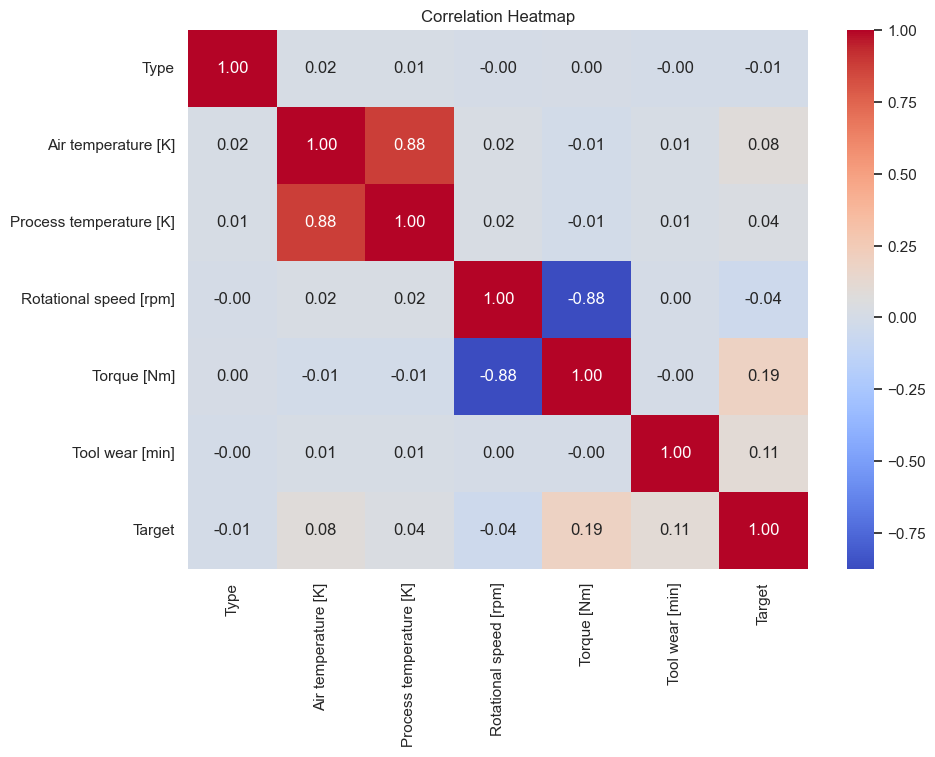

In [51]:
# Correlation heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()

In [53]:
# Feature Engineering (optional)
df['Temperature_Diff'] = df['Process temperature [K]'] - df['Air temperature [K]']

# Final feature overview
print("\nUpdated Features:")
print(df.columns)



Updated Features:
Index(['Type', 'Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Target',
       'Failure Type', 'Temperature_Diff'],
      dtype='object')


In [59]:
# Winsorization (Capping) for Outliers

def cap_outliers(df, col, lower_percentile=0.01, upper_percentile=0.99):
    lower = df[col].quantile(lower_percentile)
    upper = df[col].quantile(upper_percentile)
    df[col] = np.where(df[col] < lower, lower, df[col])
    df[col] = np.where(df[col] > upper, upper, df[col])
    return df

# Apply capping to Rotational speed and Torque
df = cap_outliers(df, 'Rotational speed [rpm]')
df = cap_outliers(df, 'Torque [Nm]')


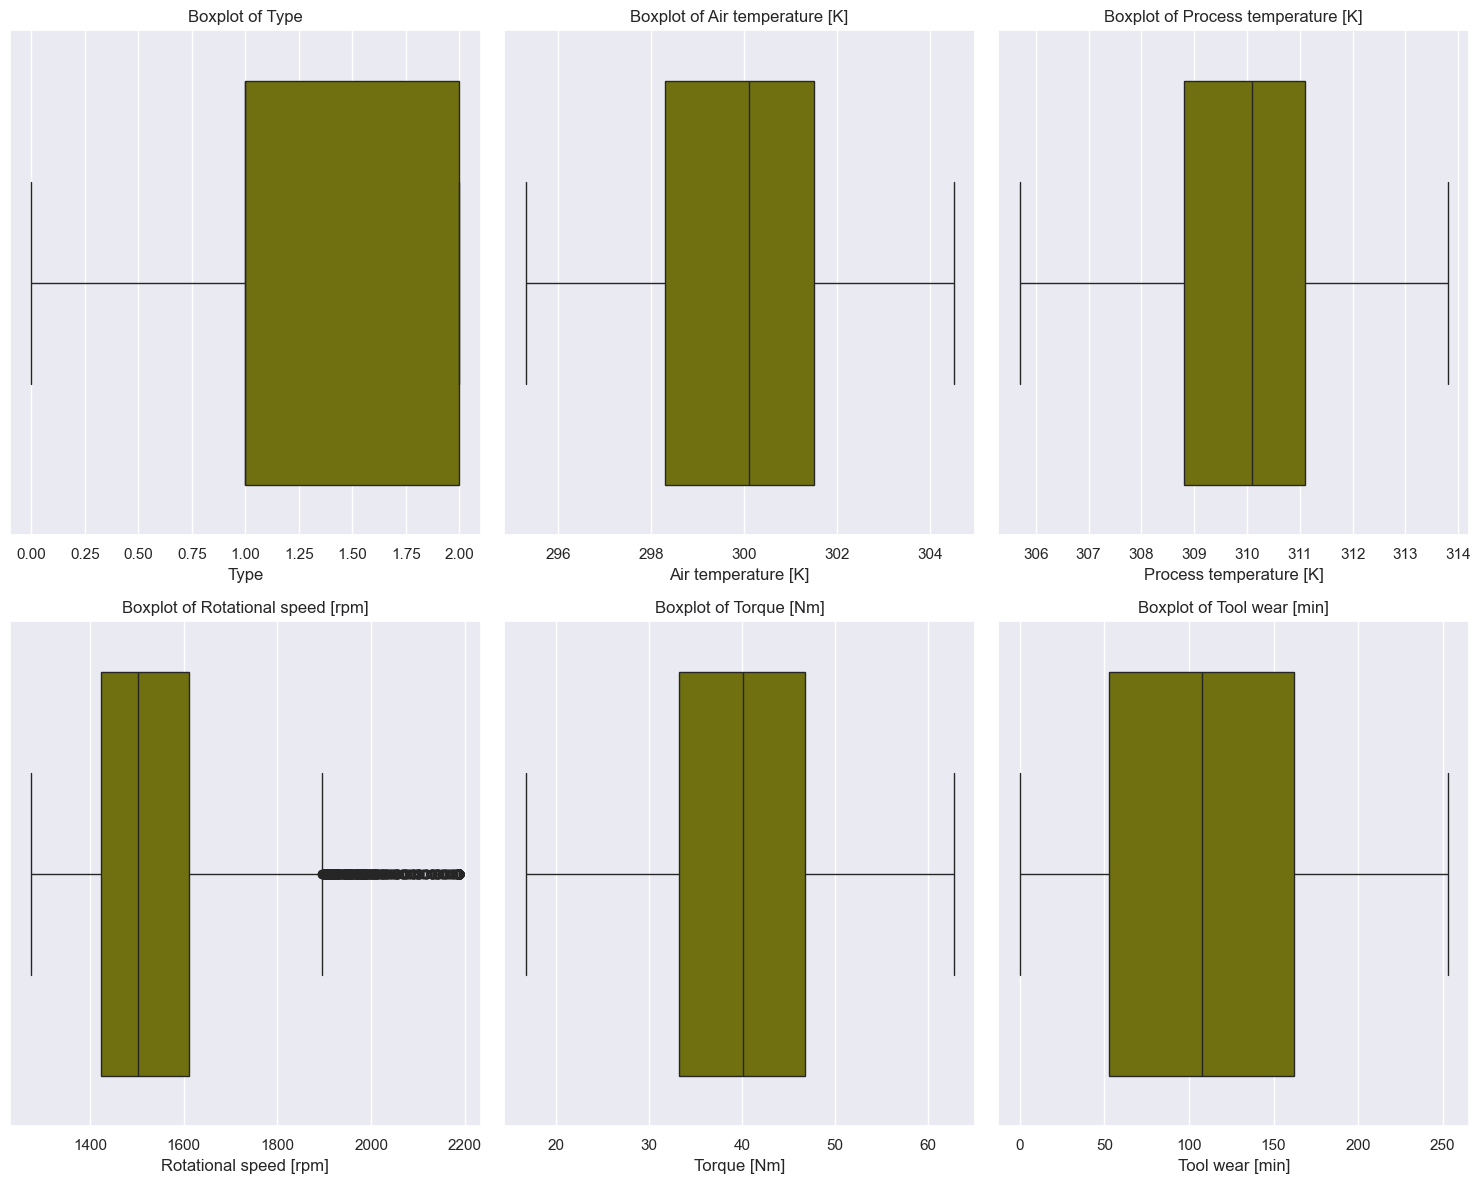

In [343]:
# Outlier detection via boxplots
fig, axs = plt.subplots(nrows=int(np.ceil(len(num_cols)/3)), ncols=3, figsize=(15, 12))
axs = axs.flatten()

for i, col in enumerate(num_cols):
    sns.boxplot(x=df[col], ax=axs[i],color='olive')
    axs[i].set_title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()

In [61]:
# Encode multiclass target (for later use)
df['Failure_Type_Code'] = df['Failure Type'].cat.codes

# Final feature list and types
print("\nFinal Data Types:")
print(df.dtypes)

# Save processed version for modeling
processed_df = df.copy()


Final Data Types:
Type                           int8
Air temperature [K]         float64
Process temperature [K]     float64
Rotational speed [rpm]      float64
Torque [Nm]                 float64
Tool wear [min]               int64
Target                        int64
Failure Type               category
Temperature_Diff            float64
Failure_Type_Code              int8
dtype: object


# Scaling and Spliting

In [85]:
binary_target = processed_df['Target']
multiclass_target = processed_df['Failure_Type_Code']

In [87]:
# Drop targets + original multiclass label
X = processed_df.drop(['Target', 'Failure Type', 'Failure_Type_Code'], axis=1)

# Identify numeric columns for scaling
numeric_features = X.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Categorical columns (if any remain)
categorical_features = list(set(X.columns) - set(numeric_features))


In [102]:
# Initialize scaler
scaler = StandardScaler()

# Scale only numeric features
X_scaled = X.copy()
X_scaled[numeric_features] = scaler.fit_transform(X[numeric_features])

# Final sanity check
print("\nSample of Scaled Features:")
print(X_scaled.head())


Sample of Scaled Features:
   Type  Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
0     2            -0.952389                -0.947360                0.085953   
1     1            -0.902393                -0.879959               -0.770185   
2     1            -0.952389                -1.014761               -0.231357   
3     1            -0.902393                -0.947360               -0.620511   
4     1            -0.902393                -0.879959               -0.770185   

   Torque [Nm]  Tool wear [min]  Temperature_Diff  
0     0.288492        -1.695984          0.498849  
1     0.646137        -1.648852          0.498849  
2     0.962908        -1.617430          0.398954  
3    -0.048716        -1.586009          0.398954  
4     0.002376        -1.554588          0.498849  


In [104]:
# Clean column names to be XGBoost-compatible (remove brackets and spaces)
X_scaled.columns = X_scaled.columns.str.replace(r"[\[\]<>\(\)]", "", regex=True).str.replace(" ", "_")


In [106]:
# Train-test split (Binary Target)
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    X_scaled, binary_target, test_size=0.2, random_state=42, stratify=binary_target
)

# Train-test split (Multiclass Target)
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X_scaled, multiclass_target, test_size=0.2, random_state=42, stratify=multiclass_target
)

# Output summary
print(f"\nBinary Classification:\nTrain size: {X_train_bin.shape[0]}, Test size: {X_test_bin.shape[0]}")
print(f"Multiclass Classification:\nTrain size: {X_train_multi.shape[0]}, Test size: {X_test_multi.shape[0]}")


Binary Classification:
Train size: 8000, Test size: 2000
Multiclass Classification:
Train size: 8000, Test size: 2000


# Model Training and Evaluation

In [109]:
# Define models
log_model = LogisticRegression(random_state=42)
rf_model = RandomForestClassifier(random_state=42)
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)


In [111]:
# Fit models
log_model.fit(X_train_bin, y_train_bin)

LogisticRegression(random_state=42)

In [113]:
rf_model.fit(X_train_bin, y_train_bin)

RandomForestClassifier(random_state=42)

In [140]:
xgb_model.fit(X_train_bin, y_train_bin)

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:52:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [142]:
# Evaluation Function with Metrics, Confusion Matrix & ROC Curve
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

    print(f"\n--- {name} ---")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print(f"ROC AUC  : {roc_auc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'{name} - ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [144]:
# Evaluate models and collect predictions + probabilities
model_results = {}

for name, (model, X_test) in models.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    model_results[name] = {
        "model": model,
        "y_pred": y_pred,
        "y_prob": y_prob,
        "conf_matrix": confusion_matrix(y_test_bin, y_pred),
        "roc": roc_curve(y_test_bin, y_prob),
        "roc_auc": roc_auc_score(y_test_bin, y_prob),
        "metrics": {
            "Accuracy": accuracy_score(y_test_bin, y_pred),
            "Precision": precision_score(y_test_bin, y_pred),
            "Recall": recall_score(y_test_bin, y_pred),
            "F1 Score": f1_score(y_test_bin, y_pred),
        }
    }


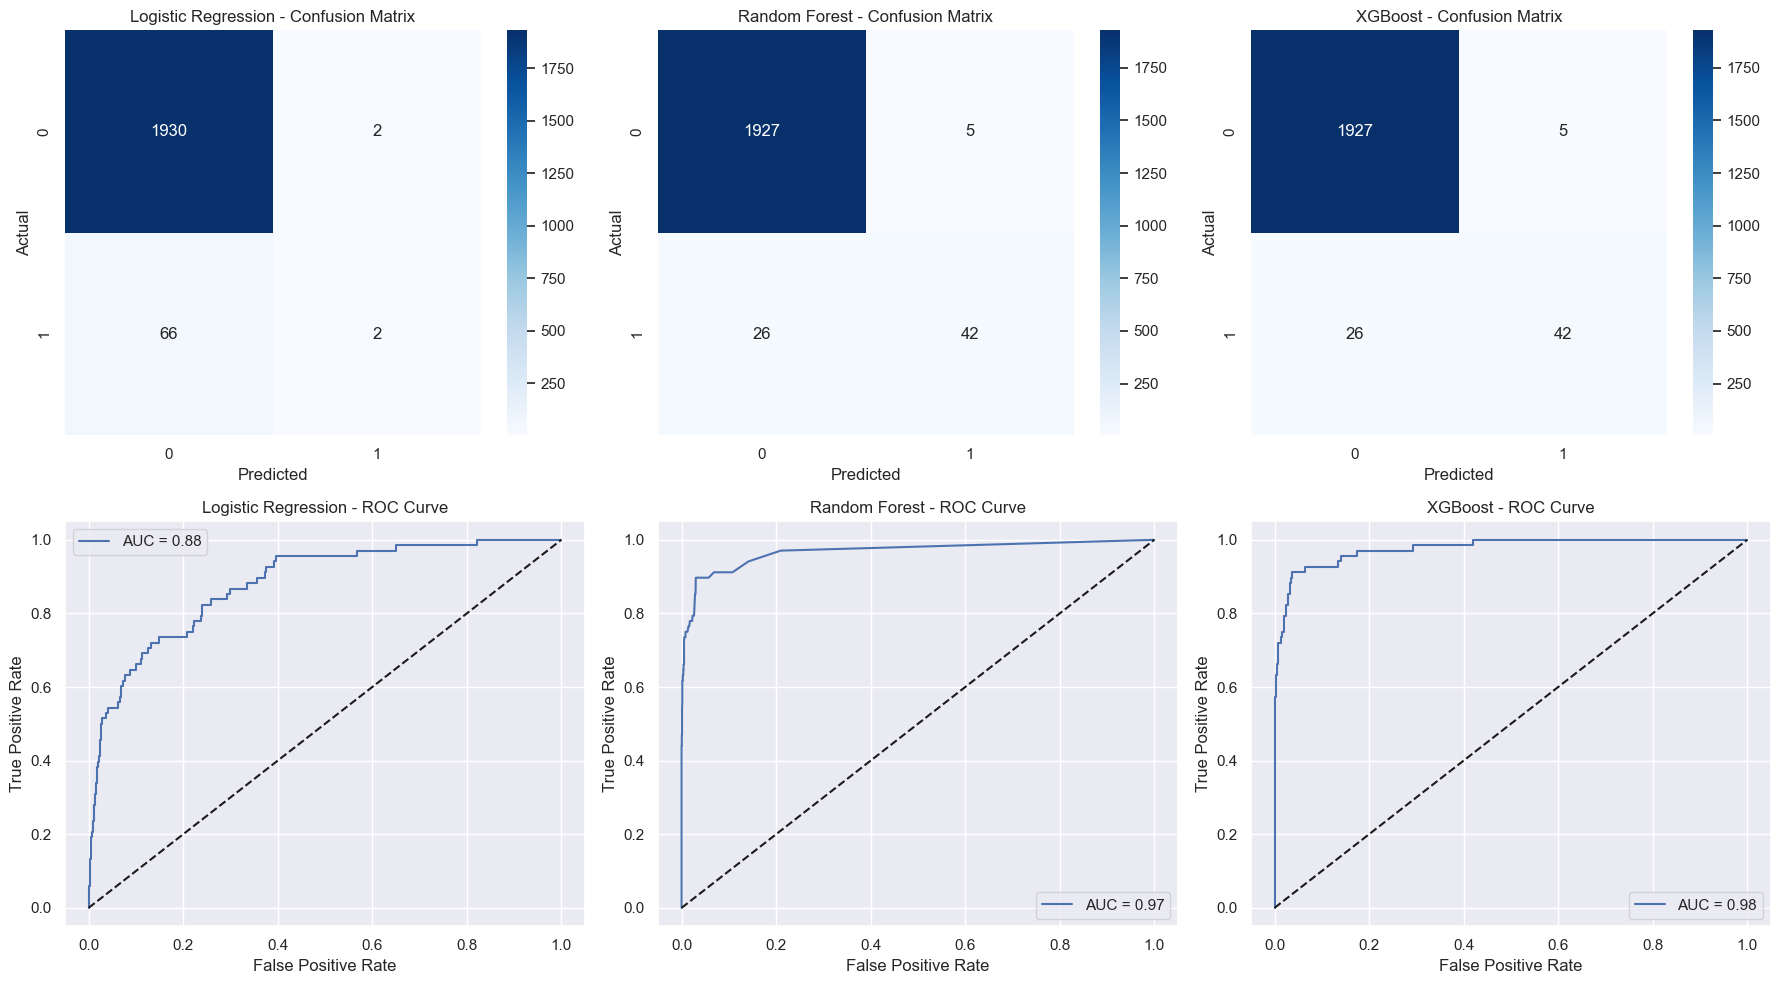

In [146]:
# Plot all Confusion Matrices and ROC Curves in a grid

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()

for idx, (name, result) in enumerate(model_results.items()):
    # Confusion Matrix (Top Row)
    sns.heatmap(result['conf_matrix'], annot=True, fmt='d', cmap='Blues', ax=axes[idx])
    axes[idx].set_title(f"{name} - Confusion Matrix")
    axes[idx].set_xlabel("Predicted")
    axes[idx].set_ylabel("Actual")

for idx, (name, result) in enumerate(model_results.items(), start=3):
    # ROC Curve (Bottom Row)
    fpr, tpr, _ = result['roc']
    axes[idx].plot(fpr, tpr, label=f"AUC = {result['roc_auc']:.2f}")
    axes[idx].plot([0, 1], [0, 1], 'k--')
    axes[idx].set_title(f"{name} - ROC Curve")
    axes[idx].set_xlabel("False Positive Rate")
    axes[idx].set_ylabel("True Positive Rate")
    axes[idx].legend()
    axes[idx].grid(True)

plt.tight_layout()
plt.show()


In [137]:
# Display evaluation metrics in tabular form
metrics_df = pd.DataFrame({name: res['metrics'] for name, res in model_results.items()})
print(metrics_df.T.round(4))


                     Accuracy  Precision  Recall  F1 Score
Logistic Regression    0.9660     0.5000  0.0294    0.0556
Random Forest          0.9845     0.8936  0.6176    0.7304
XGBoost                0.9845     0.8936  0.6176    0.7304


| Model               | Accuracy | Precision | Recall | F1 Score |
|---------------------|----------|-----------|--------|----------|
| Logistic Regression | 0.9660   | 0.5000    | 0.0294 | 0.0556   |
| Random Forest       | 0.9845   | 0.8936    | 0.6176 | 0.7304   |
| XGBoost             | 0.9845   | 0.8936    | 0.6176 | 0.7304   |


# SHAP (SHapley Additive exPlanations) helps you:
Understand which features influence predictions

Get global feature importance (model-wide)

Explore local explanations (per individual prediction)

In [148]:
import shap
shap.initjs()

# Use TreeExplainer for tree-based models
explainer_rf = shap.TreeExplainer(rf_model)
explainer_xgb = shap.Explainer(xgb_model)

# Compute SHAP values on test data
shap_values_rf = explainer_rf.shap_values(X_test_bin)
shap_values_xgb = explainer_xgb(X_test_bin)

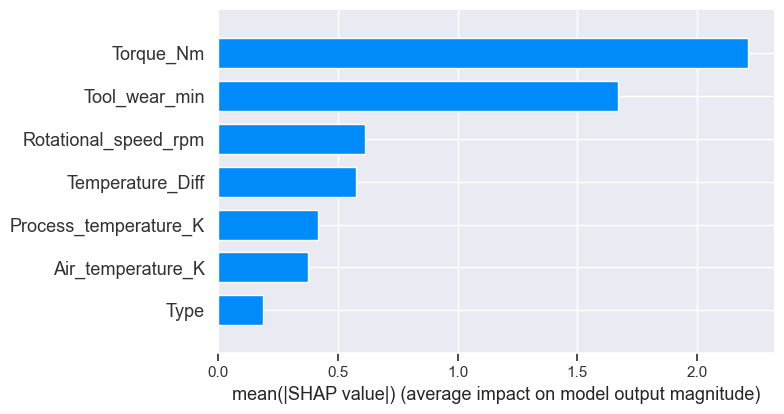

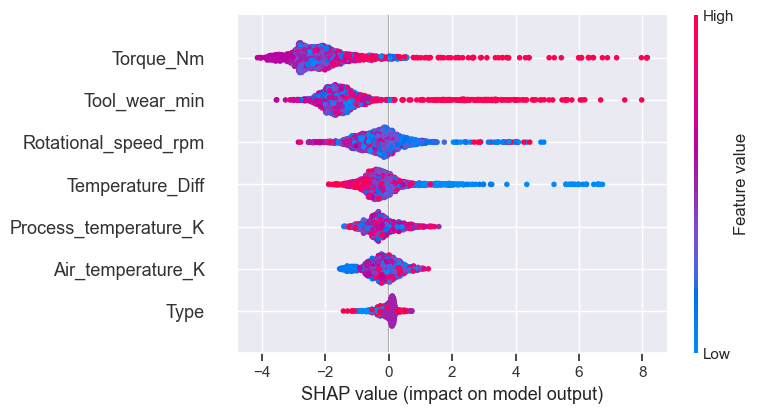

In [156]:
explainer_xgb = shap.Explainer(xgb_model)
shap_values_xgb = explainer_xgb(X_test_bin)

shap.summary_plot(shap_values_xgb, X_test_bin, plot_type="bar")
shap.summary_plot(shap_values_xgb, X_test_bin)


In [158]:
print("Type of shap_values_rf:", type(shap_values_rf))
if isinstance(shap_values_rf, list):
    print("shap_values_rf is a list with", len(shap_values_rf), "elements")
    print("Shape of class 1 SHAP values:", shap_values_rf[1].shape)
else:
    print("Shape of shap_values_rf:", shap_values_rf.shape)

print("Shape of X_test_bin:", X_test_bin.shape)


Type of shap_values_rf: <class 'numpy.ndarray'>
Shape of shap_values_rf: (2000, 7, 2)
Shape of X_test_bin: (2000, 7)


 SHAP Summary for Random Forest (Class 1 - Failure)


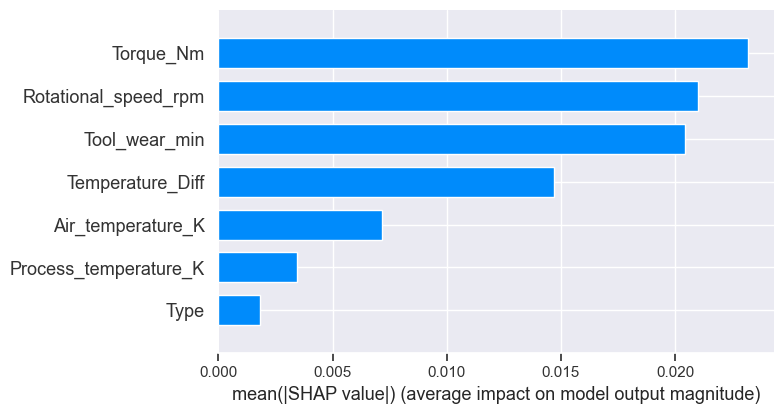

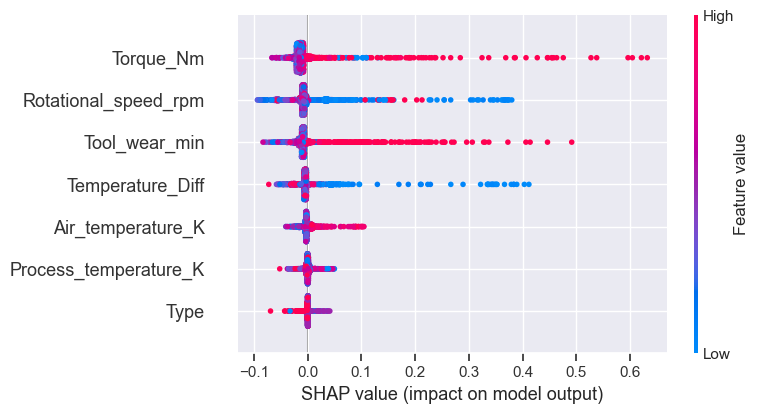

In [162]:
# Extract and plot SHAP for class 1 (failure) from Random Forest
shap_values_rf_class1 = shap_values_rf[:, :, 1]

print(" SHAP Summary for Random Forest (Class 1 - Failure)")
shap.summary_plot(shap_values_rf_class1, X_test_bin, plot_type="bar")
shap.summary_plot(shap_values_rf_class1, X_test_bin)


### SHAP Force Plot (for Random Forest and XGBoost)

In [205]:
def get_top_shap_features(shap_values, feature_values, top_n=3):
    """Filter SHAP values and features to top_n most impactful features"""
    abs_vals = np.abs(shap_values)
    top_indices = np.argsort(abs_vals)[-top_n:]
    return shap_values[top_indices], feature_values[top_indices], top_indices


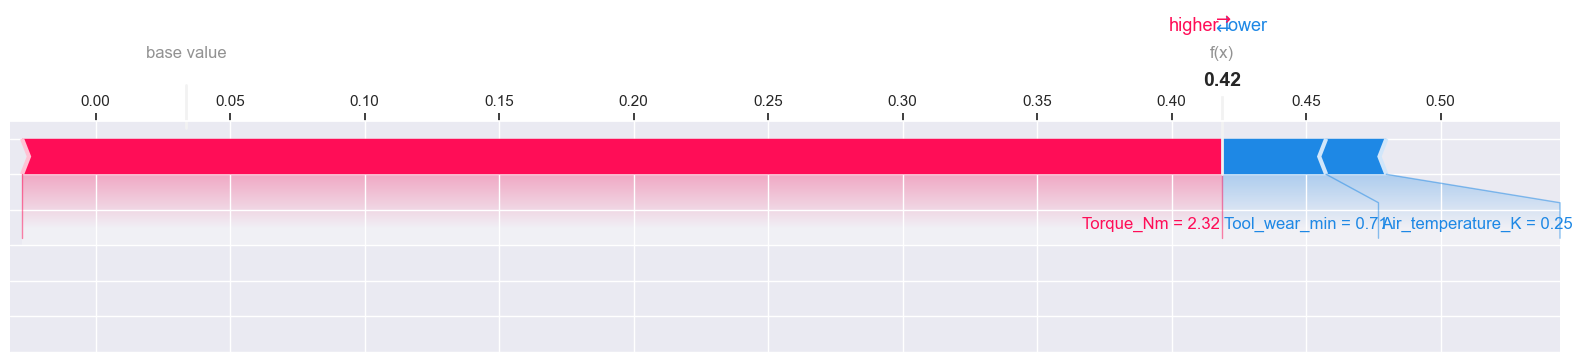

In [207]:
# Choose a test instance
i = 0
full_instance = X_test_bin.iloc[i].round(2)

# Extract SHAP values and feature values
shap_vals = shap_values_rf_class1[i]
feature_vals = full_instance.values
feature_names = full_instance.index

# Filter top 3 features
shap_top, feat_top_vals, top_indices = get_top_shap_features(shap_vals, feature_vals, top_n=3)
feat_top_names = feature_names[top_indices]

# Create a simplified feature dictionary
top_instance_series = pd.Series(feat_top_vals, index=feat_top_names)


shap.force_plot(
    explainer_rf.expected_value[1],
    shap_top,
    top_instance_series,
    matplotlib=True
)



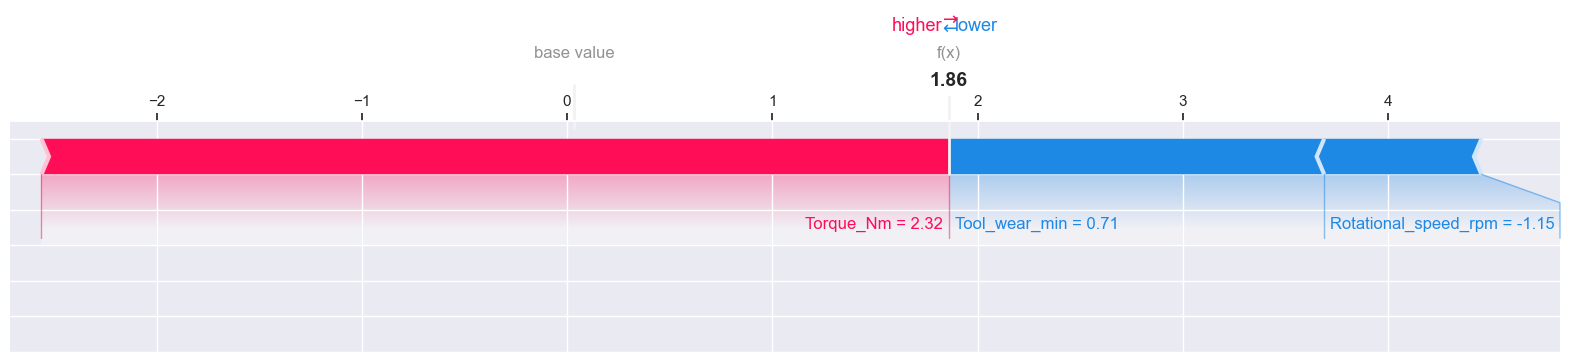

In [209]:
shap_vals = shap_values_xgb[i].values
feature_vals = full_instance.values
feature_names = full_instance.index

shap_top, feat_top_vals, top_indices = get_top_shap_features(shap_vals, feature_vals, top_n=3)
feat_top_names = feature_names[top_indices]
top_instance_series = pd.Series(feat_top_vals, index=feat_top_names)


shap.force_plot(
    explainer_rf.expected_value[1],
    shap_top,
    top_instance_series,
    matplotlib=True
)



# Multi Class Classification

In [213]:
# Check class distribution
print("Full Dataset Class Distribution:")
print(df["Failure_Type_Code"].value_counts())

print("\nTrain Set:")
print(y_train_multi.value_counts())

print("\nTest Set:")
print(y_test_multi.value_counts())


Full Dataset Class Distribution:
Failure_Type_Code
1    9652
0     112
3      95
2      78
5      45
4      18
Name: count, dtype: int64

Train Set:
Failure_Type_Code
1    7722
0      90
3      76
2      62
5      36
4      14
Name: count, dtype: int64

Test Set:
Failure_Type_Code
1    1930
0      22
3      19
2      16
5       9
4       4
Name: count, dtype: int64


### Multi Class Model Training 

In [216]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix


# Initialize models
log_model_mc = LogisticRegression(multi_class='multinomial', max_iter=1000, random_state=42)
rf_model_mc = RandomForestClassifier(random_state=42)
xgb_model_mc = XGBClassifier(objective='multi:softprob', num_class=6, eval_metric='mlogloss', use_label_encoder=False, random_state=42)

# Train
log_model_mc.fit(X_train_multi, y_train_multi)
rf_model_mc.fit(X_train_multi, y_train_multi)
xgb_model_mc.fit(X_train_multi, y_train_multi)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:03:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=6, ...)

In [227]:
# Apply SMOTE to balance the multiclass training data
from imblearn.over_sampling import SMOTE
from collections import Counter

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_multi, y_train_multi)

# Check new class distribution
print("Balanced class distribution:", Counter(y_train_smote))


Balanced class distribution: Counter({1: 7722, 5: 7722, 4: 7722, 3: 7722, 0: 7722, 2: 7722})


In [229]:
# Train models using SMOTE-resampled data
log_model_mc.fit(X_train_smote, y_train_smote)
rf_model_mc.fit(X_train_smote, y_train_smote)
xgb_model_mc.fit(X_train_smote, y_train_smote)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:18:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None, num_class=6, ...)

In [231]:
models_mc = {
    "Logistic Regression": log_model_mc,
    "Random Forest": rf_model_mc,
    "XGBoost": xgb_model_mc
}



=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.29      1.00      0.44        22
           1       1.00      0.66      0.80      1930
           2       0.37      1.00      0.54        16
           3       0.16      0.89      0.28        19
           4       0.00      0.25      0.00         4
           5       0.04      0.44      0.08         9

    accuracy                           0.67      2000
   macro avg       0.31      0.71      0.36      2000
weighted avg       0.97      0.67      0.78      2000



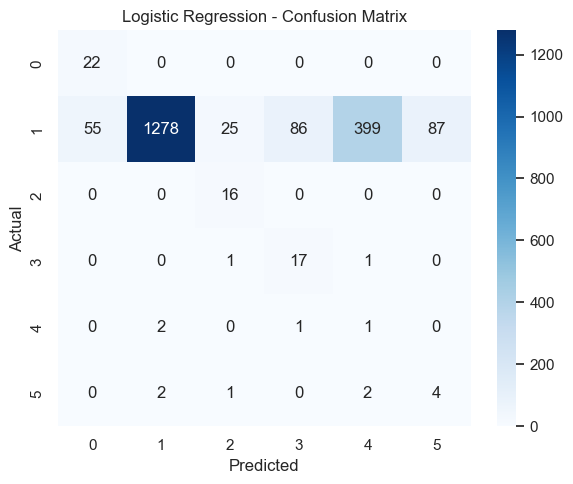


=== Random Forest ===
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        22
           1       0.99      0.98      0.98      1930
           2       0.75      0.75      0.75        16
           3       0.40      0.63      0.49        19
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00         9

    accuracy                           0.97      2000
   macro avg       0.51      0.56      0.53      2000
weighted avg       0.97      0.97      0.97      2000



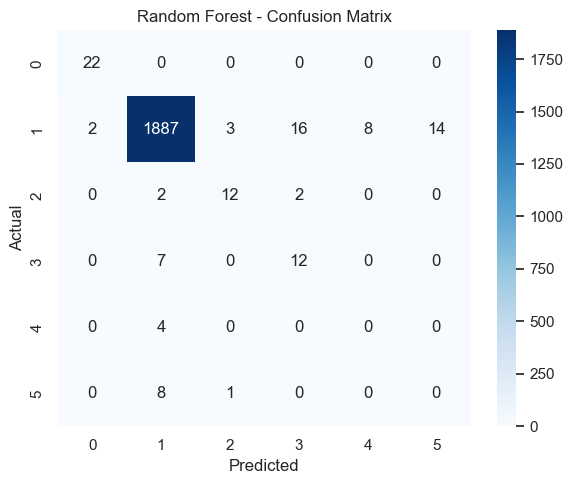


=== XGBoost ===
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        22
           1       0.99      0.95      0.97      1930
           2       0.73      1.00      0.84        16
           3       0.32      0.63      0.43        19
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00         9

    accuracy                           0.94      2000
   macro avg       0.49      0.60      0.53      2000
weighted avg       0.97      0.94      0.96      2000



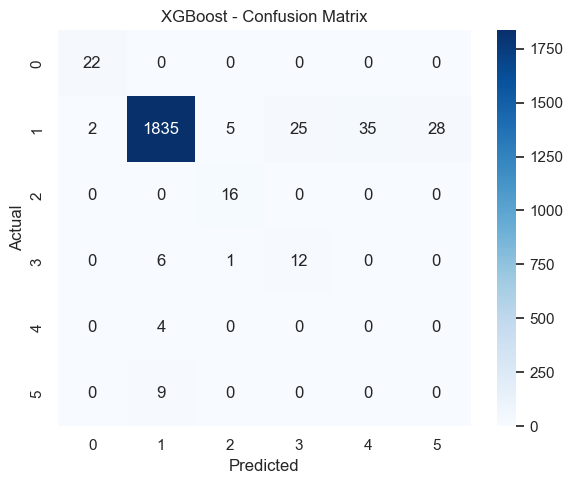

In [235]:
for name, model in models_mc.items():
    evaluate_multiclass_model(name, model, X_test_multi, y_test_multi)


In [237]:
# Logistic Regression (multiclass, balanced)
log_model_mc = LogisticRegression(
    multi_class='multinomial',
    class_weight='balanced',
    solver='lbfgs',
    max_iter=1000,
    random_state=42
)

# Random Forest (with class weights)
rf_model_mc = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced',
    random_state=42
)

# XGBoost: compute sample weights for imbalance handling
from sklearn.utils.class_weight import compute_sample_weight
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train_multi)

xgb_model_mc = XGBClassifier(
    objective='multi:softprob',
    num_class=6,
    eval_metric='mlogloss',
    use_label_encoder=False,
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)


In [239]:
log_model_mc.fit(X_train_multi, y_train_multi)
rf_model_mc.fit(X_train_multi, y_train_multi)
xgb_model_mc.fit(X_train_multi, y_train_multi, sample_weight=sample_weights)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:28:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None, num_class=6, ...)


=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.23      0.95      0.38        22
           1       1.00      0.61      0.76      1930
           2       0.29      1.00      0.45        16
           3       0.15      0.89      0.25        19
           4       0.00      0.25      0.00         4
           5       0.05      0.67      0.09         9

    accuracy                           0.62      2000
   macro avg       0.29      0.73      0.32      2000
weighted avg       0.97      0.62      0.74      2000



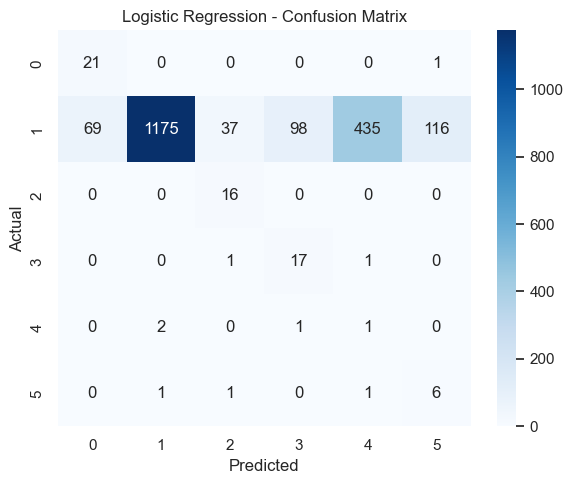


=== Random Forest ===
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        22
           1       0.98      1.00      0.99      1930
           2       0.89      0.50      0.64        16
           3       0.38      0.16      0.22        19
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00         9

    accuracy                           0.98      2000
   macro avg       0.54      0.43      0.47      2000
weighted avg       0.97      0.98      0.97      2000



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


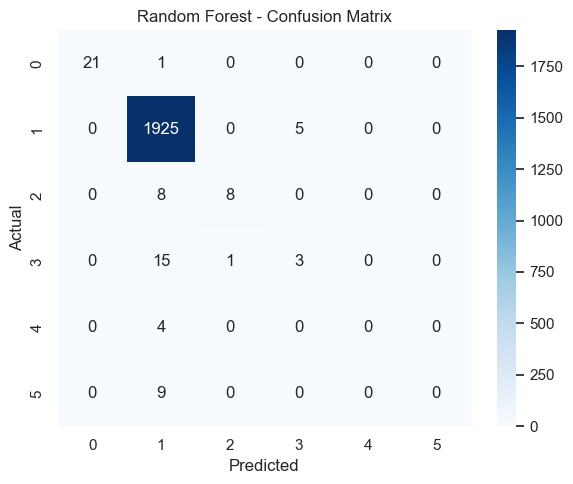


=== XGBoost ===
              precision    recall  f1-score   support

           0       0.88      1.00      0.94        22
           1       0.99      0.98      0.98      1930
           2       0.67      1.00      0.80        16
           3       0.41      0.68      0.51        19
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00         9

    accuracy                           0.97      2000
   macro avg       0.49      0.61      0.54      2000
weighted avg       0.98      0.97      0.97      2000



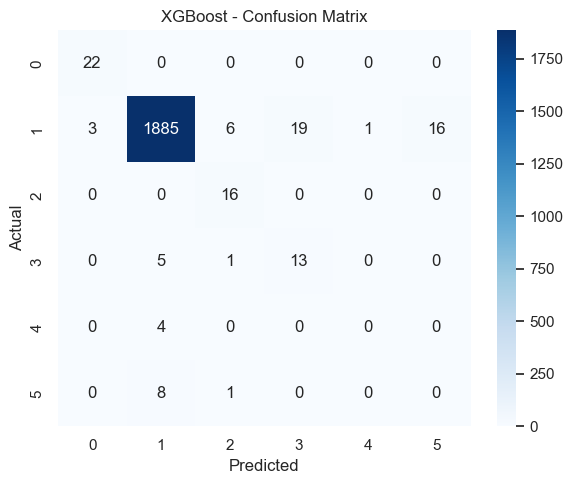

In [345]:
# Evaluation loop (confusion matrix, classification_report)
for name, model in models_mc.items():
    evaluate_multiclass_model(name, model, X_test_multi, y_test_multi)


you're making the right decision by sticking with SMOTE. It prioritizes recall and fairness across failure types, which is critical in predictive maintenance where missing a rare failure can be far more costly than a few false alarms.

### SHAP for XGBoost (SMOTE-trained)

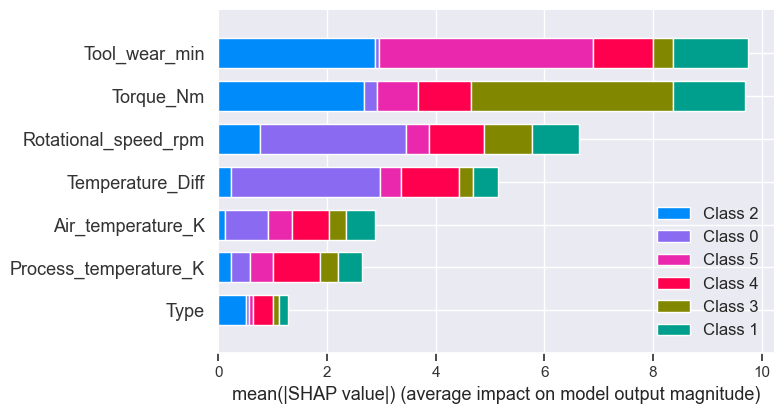

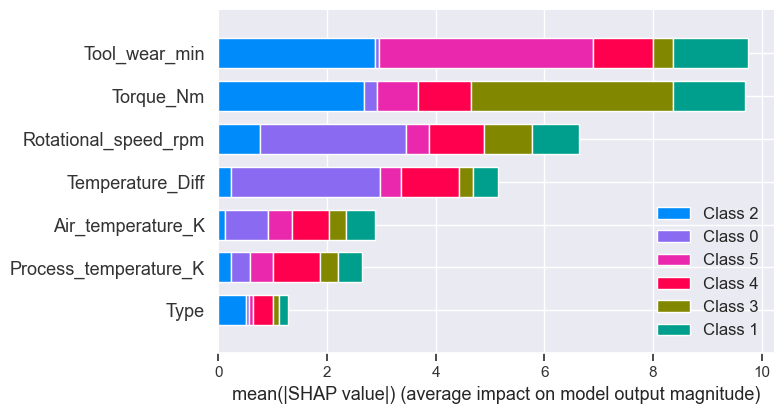

In [247]:
# SHAP for XGBoost
explainer_xgb = shap.Explainer(xgb_model_mc)
shap_values_xgb = explainer_xgb(X_test_multi)

# Summary (global importance)
shap.summary_plot(shap_values_xgb, X_test_multi, plot_type="bar")
shap.summary_plot(shap_values_xgb, X_test_multi)


### SHAP for Random Forest (SMOTE-trained)

100%|===================| 11947/12000 [02:32<00:00]        

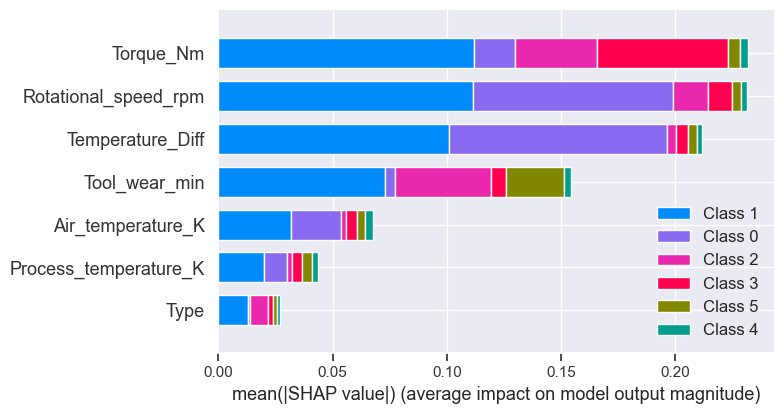

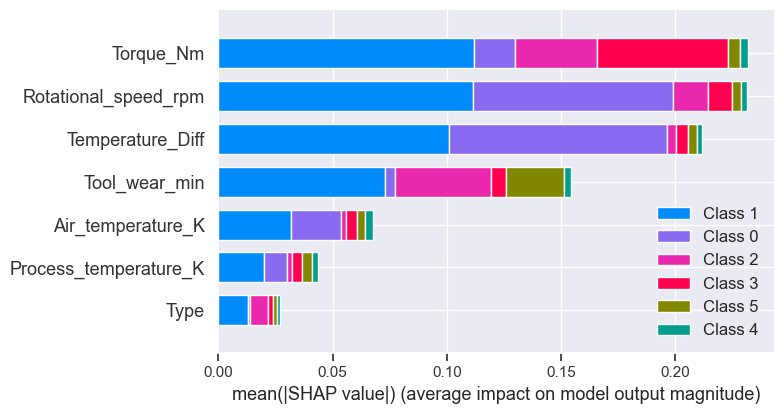

In [252]:
# SHAP for Random Forest
explainer_rf = shap.Explainer(rf_model_mc, X_train_smote)
shap_values_rf = explainer_rf(X_test_multi, check_additivity=False)


# Summary (global importance)
shap.summary_plot(shap_values_rf, X_test_multi, plot_type="bar")
shap.summary_plot(shap_values_rf, X_test_multi)


In [260]:
explainer_rf = shap.TreeExplainer(rf_model_mc)
shap_values_rf = explainer_rf.shap_values(X_test_multi)  # This returns a list of arrays, one per class


In [266]:
print(f"Shape of shap_vals_sample: {shap_vals_sample.shape}")
print(f"Shape of features_sample_values: {features_sample_values.shape}")
print(f"Number of feature names: {len(X_test_multi.columns.tolist())}")


Shape of shap_vals_sample: (6,)
Shape of features_sample_values: (7,)
Number of feature names: 7


In [268]:
print(f"Train shape: {X_train_smote.shape}")
print(f"Test shape: {X_test_multi.shape}")
print("Train columns:", X_train_smote.columns.tolist())
print("Test columns :", X_test_multi.columns.tolist())


Train shape: (46332, 7)
Test shape: (2000, 7)
Train columns: ['Type', 'Air_temperature_K', 'Process_temperature_K', 'Rotational_speed_rpm', 'Torque_Nm', 'Tool_wear_min', 'Temperature_Diff']
Test columns : ['Type', 'Air_temperature_K', 'Process_temperature_K', 'Rotational_speed_rpm', 'Torque_Nm', 'Tool_wear_min', 'Temperature_Diff']


In [274]:
explainer_rf = shap.TreeExplainer(rf_model_mc, X_train_smote)



In [276]:
print("Shape of shap_values_rf[0]:", shap_values_rf[0].shape)
print("Shape of X_test_multi:", X_test_multi.shape)


Shape of shap_values_rf[0]: (7, 6)
Shape of X_test_multi: (2000, 7)


In [280]:
print(f"shap_values_rf shape: {np.array(shap_values_rf).shape}")  # should be (6, 2000, 7)


shap_values_rf shape: (2000, 7, 6)


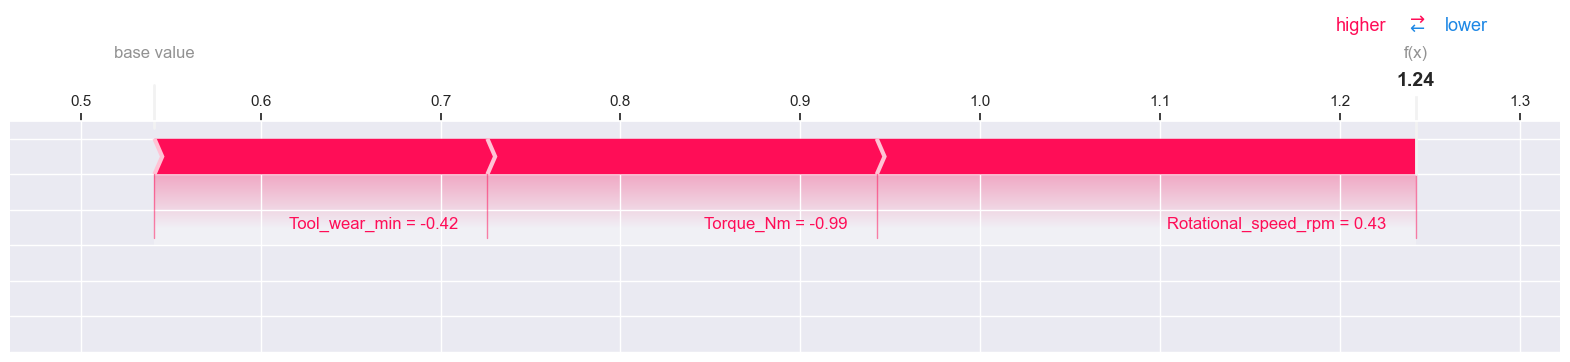

In [294]:
sample_index = 0
class_index = 1  # whichever class you’re inspecting

# Full SHAP values and feature values
shap_vals_sample = shap_values_rf[sample_index, :, class_index]
features_sample = X_test_multi.iloc[sample_index]
feature_names = X_test_multi.columns

# Get top 3 features by absolute SHAP value
top_n = 3
top_indices = np.argsort(np.abs(shap_vals_sample))[-top_n:]
top_shap_values = shap_vals_sample[top_indices]
top_features = features_sample.iloc[top_indices].round(2).values
top_feature_names = feature_names[top_indices]

# Plot simplified force plot
shap.force_plot(
    base_value=explainer_rf.expected_value[class_index],
    shap_values=top_shap_values,
    features=top_features,
    feature_names=top_feature_names.tolist(),
    matplotlib=True
)


# Hyperparameter Tuning

In [309]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define hyperparameter space
param_dist_rf = {
    'n_estimators': randint(100, 1000),
    'max_depth': randint(3, 20),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10),
    'bootstrap': [True, False]
}

# Initialize model
rf_model = RandomForestClassifier(random_state=42)

# RandomizedSearchCV
rf_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist_rf,
    n_iter=30,
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit on SMOTE-balanced training set
rf_search.fit(X_train_smote, y_train_smote)  # Correct


# Best model and score
print("Best RF Parameters:", rf_search.best_params_)
print("Best RF CV Score:", rf_search.best_score_)

# Save best model
best_rf_model = rf_search.best_estimator_


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best RF Parameters: {'bootstrap': False, 'max_depth': 19, 'min_samples_leaf': 4, 'min_samples_split': 3, 'n_estimators': 971}
Best RF CV Score: 0.9893594060260726


In [314]:
from xgboost import XGBClassifier
from scipy.stats import uniform

# Define hyperparameter space
param_dist_xgb = {
    'n_estimators': randint(100, 1000),
    'max_depth': randint(3, 20),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'gamma': uniform(0, 5)
}

# Initialize model
xgb_model = XGBClassifier(eval_metric='mlogloss', random_state=42)

# RandomizedSearchCV
xgb_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist_xgb,
    n_iter=30,
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit on SMOTE-balanced training set
xgb_search.fit(X_train_smote, y_train_smote)

# Best model and score
print("Best XGB Parameters:", xgb_search.best_params_)
print("Best XGB CV Score:", xgb_search.best_score_)

# Save best model
best_xgb_model = xgb_search.best_estimator_


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best XGB Parameters: {'colsample_bytree': 0.5035331526098588, 'gamma': 0.11531212520707879, 'learning_rate': 0.16743239807751675, 'max_depth': 12, 'n_estimators': 575, 'subsample': 0.9868777594207296}
Best XGB CV Score: 0.994539411206078


In [318]:
from sklearn.ensemble import RandomForestClassifier

# Best Random Forest parameters from tuning
rf_best_params = {
    'bootstrap': False,
    'max_depth': 19,
    'min_samples_leaf': 4,
    'min_samples_split': 3,
    'n_estimators': 971
}

# Initialize the final RF model with best params
rf_best = RandomForestClassifier(**rf_best_params, random_state=42)


In [320]:
from xgboost import XGBClassifier

# Best XGBoost parameters from tuning
xgb_best_params = {
    'colsample_bytree': 0.5035,
    'gamma': 0.1153,
    'learning_rate': 0.1674,
    'max_depth': 12,
    'n_estimators': 575,
    'subsample': 0.9869
}

# Initialize the final XGB model with best params
xgb_best = XGBClassifier(**xgb_best_params, 
                         use_label_encoder=False, 
                         eval_metric='mlogloss',
                         random_state=42)


In [322]:
# Fit models using X_train_smote and y_train_smote
rf_best.fit(X_train_smote, y_train_smote)
xgb_best.fit(X_train_smote, y_train_smote)


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:54:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5035, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=0.1153,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1674, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=12, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=575, n_jobs=None,
              num_parallel_tree=None, ...)

In [323]:
from sklearn.metrics import classification_report

# Predictions
rf_preds = rf_best.predict(X_test_multi)
xgb_preds = xgb_best.predict(X_test_multi)

# Reports
print("=== Random Forest Report ===")
print(classification_report(y_test_multi, rf_preds))

print("\n=== XGBoost Report ===")
print(classification_report(y_test_multi, xgb_preds))


=== Random Forest Report ===
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        22
           1       0.99      0.95      0.97      1930
           2       0.80      0.75      0.77        16
           3       0.40      0.63      0.49        19
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00         9

    accuracy                           0.94      2000
   macro avg       0.52      0.56      0.53      2000
weighted avg       0.97      0.94      0.96      2000


=== XGBoost Report ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       0.99      0.98      0.98      1930
           2       0.81      0.81      0.81        16
           3       0.32      0.53      0.40        19
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00         9

    accuracy            

### SHAP Force Plot – Tuned Random Forest

100%|===================| 11994/12000 [26:00<00:00]        

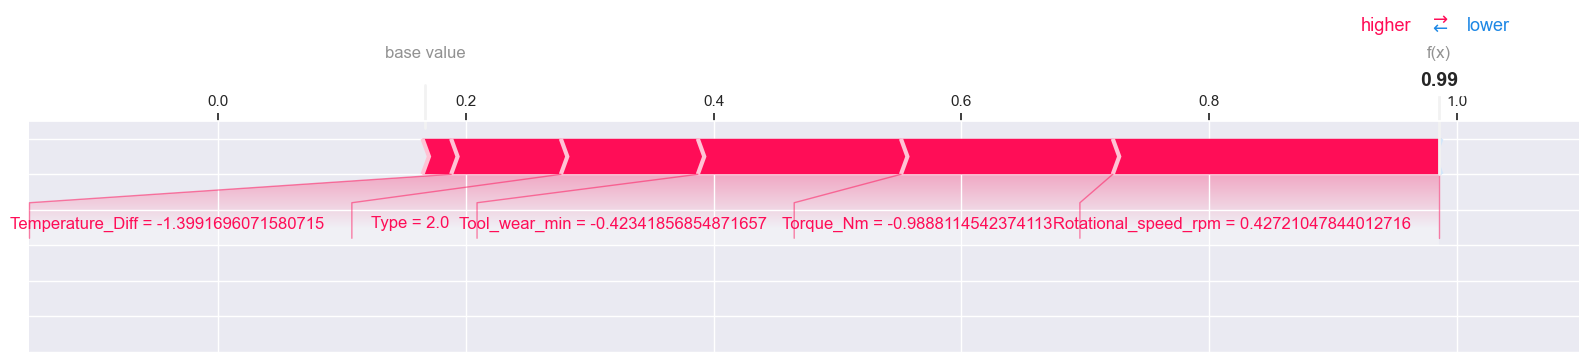

In [327]:
import shap

# Re-explain using the tuned Random Forest model
explainer_rf_tuned = shap.Explainer(rf_search.best_estimator_, X_train_smote)
shap_values_rf_tuned = explainer_rf_tuned(X_test_multi)

# Choose a sample index and class index to visualize
sample_index = 0
class_index = 1  # Adjust to 0–5 for other classes

# Plot force plot for selected sample and class
shap.force_plot(
    base_value=explainer_rf_tuned.expected_value[class_index],
    shap_values=shap_values_rf_tuned[sample_index].values[:, class_index],
    features=X_test_multi.iloc[sample_index],
    feature_names=X_test_multi.columns.tolist(),
    matplotlib=True
)


### SHAP Force Plot – Tuned XGBoost

100%|===================| 11974/12000 [03:16<00:00]        

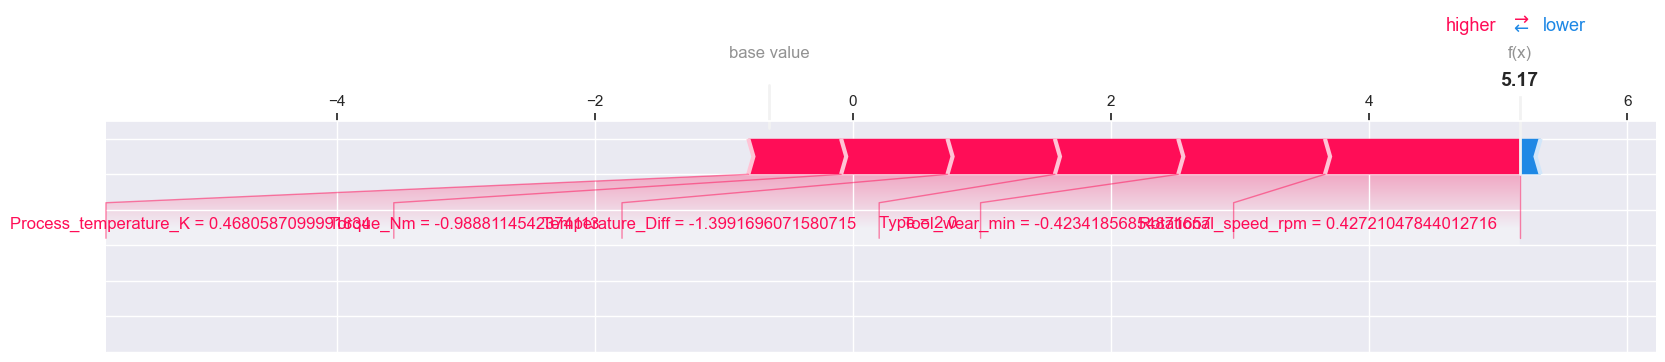

In [ ]:
# Re-explain using the tuned XGBoost model
explainer_xgb_tuned = shap.Explainer(xgb_search.best_estimator_, X_train_smote)
shap_values_xgb_tuned = explainer_xgb_tuned(X_test_multi)

# Plot force plot for the same sample and class
shap.force_plot(
    base_value=explainer_xgb_tuned.expected_value[class_index],
    shap_values=shap_values_xgb_tuned[sample_index].values[:, class_index],
    features=X_test_multi.iloc[sample_index],
    feature_names=X_test_multi.columns.tolist(),
    matplotlib=True
)


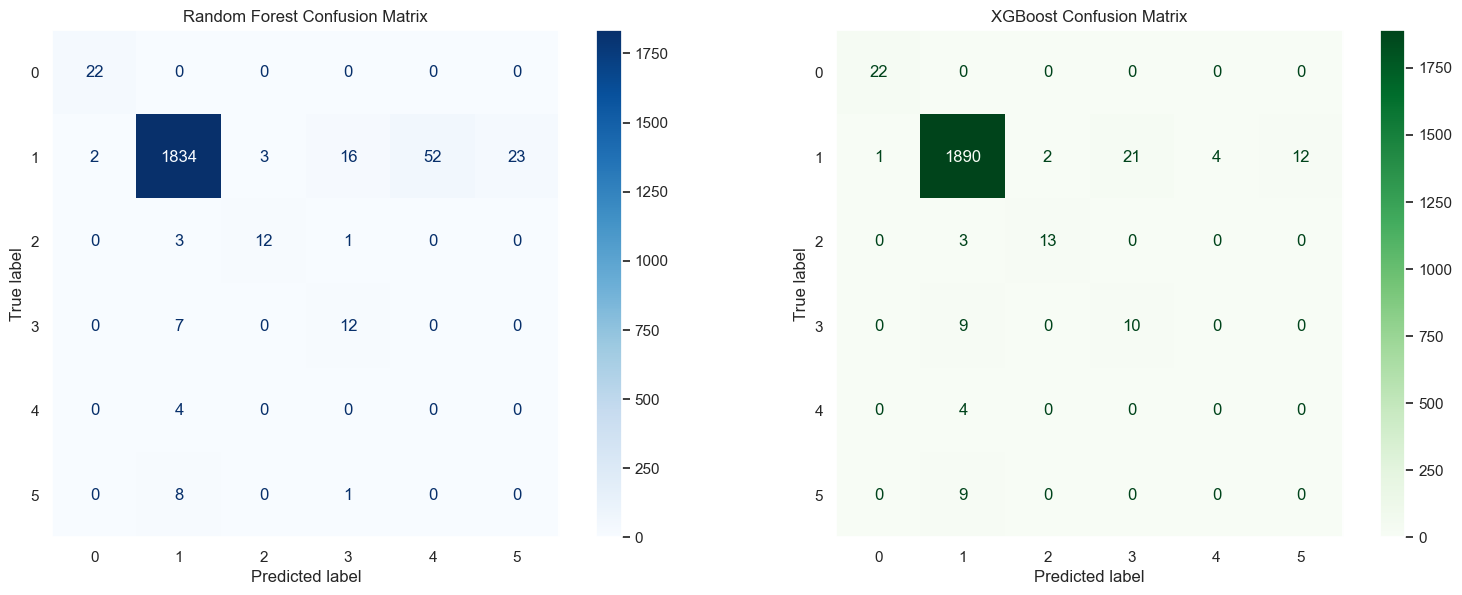

In [335]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predictions
rf_y_pred = rf_search.best_estimator_.predict(X_test_multi)
xgb_y_pred = xgb_search.best_estimator_.predict(X_test_multi)

# Create confusion matrices
rf_cm = confusion_matrix(y_test_multi, rf_y_pred)
xgb_cm = confusion_matrix(y_test_multi, xgb_y_pred)
labels = sorted(y_test_multi.unique())  # Ensure consistent class order

# Plot side-by-side confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Random Forest
disp_rf = ConfusionMatrixDisplay(confusion_matrix=rf_cm, display_labels=labels)
disp_rf.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title("Random Forest Confusion Matrix")
axes[0].grid(False)

# XGBoost
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=xgb_cm, display_labels=labels)
disp_xgb.plot(ax=axes[1], cmap='Greens', values_format='d')
axes[1].set_title("XGBoost Confusion Matrix")
axes[1].grid(False)

plt.tight_layout()
plt.show()


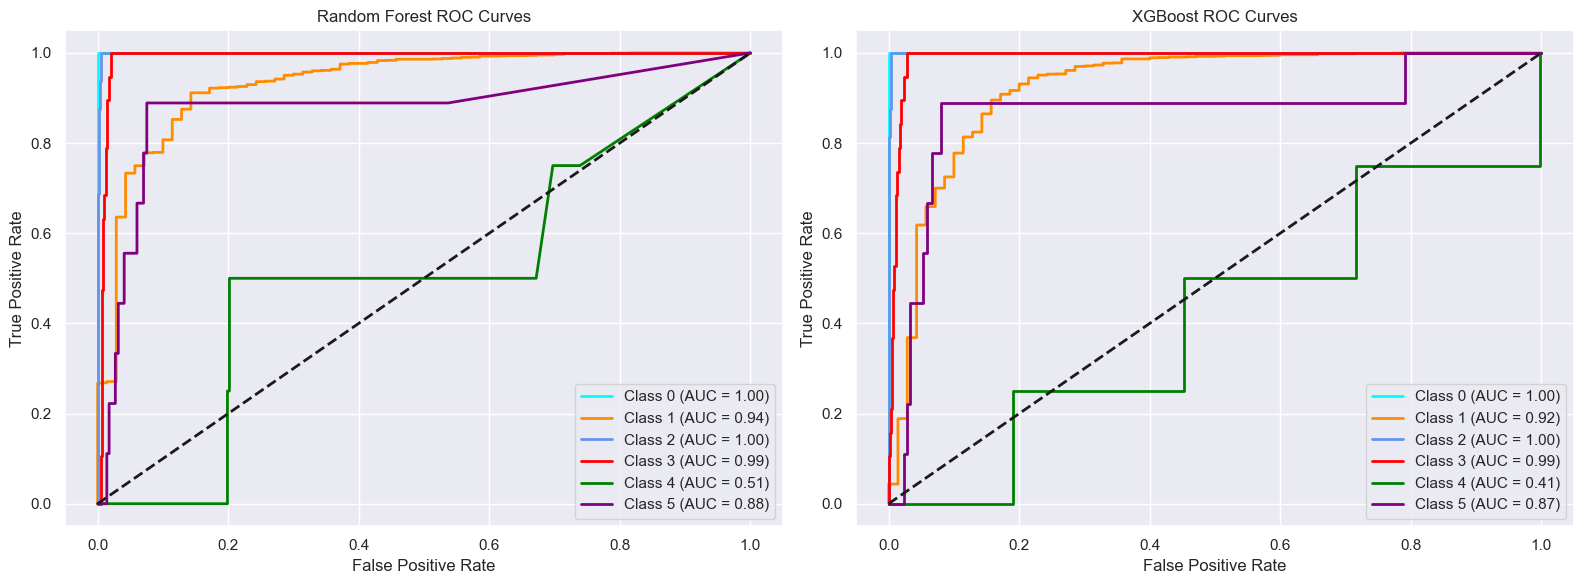

In [337]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from itertools import cycle
import numpy as np

# Binarize the output for multiclass
y_test_bin = label_binarize(y_test_multi, classes=[0, 1, 2, 3, 4, 5])
n_classes = y_test_bin.shape[1]

# Get predicted probabilities
rf_proba = rf_best.predict_proba(X_test_multi)
xgb_proba = xgb_best.predict_proba(X_test_multi)

# Compute ROC curve and ROC area for each class
fpr_rf = dict()
tpr_rf = dict()
roc_auc_rf = dict()

fpr_xgb = dict()
tpr_xgb = dict()
roc_auc_xgb = dict()

for i in range(n_classes):
    fpr_rf[i], tpr_rf[i], _ = roc_curve(y_test_bin[:, i], rf_proba[:, i])
    roc_auc_rf[i] = auc(fpr_rf[i], tpr_rf[i])
    
    fpr_xgb[i], tpr_xgb[i], _ = roc_curve(y_test_bin[:, i], xgb_proba[:, i])
    roc_auc_xgb[i] = auc(fpr_xgb[i], tpr_xgb[i])

# Plot ROC curves for each model
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple'])
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr_rf[i], tpr_rf[i], color=color, lw=2,
             label='Class {0} (AUC = {1:0.2f})'.format(i, roc_auc_rf[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.title('Random Forest ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr_xgb[i], tpr_xgb[i], color=color, lw=2,
             label='Class {0} (AUC = {1:0.2f})'.format(i, roc_auc_xgb[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.title('XGBoost ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()


In [339]:
import joblib

# Save models
joblib.dump(rf_best, "random_forest_model.pkl")
joblib.dump(xgb_best, "xgboost_model.pkl")


['xgboost_model.pkl']

In [341]:
import joblib
joblib.dump(xgb_best, "Xgboost_model.pkl")


['Xgboost_model.pkl']